In [1]:
import camb
from camb import model, initialpower
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import math

np.set_printoptions(16)

import warnings
warnings.filterwarnings("ignore")

Nside=512

In [2]:
# GENERATE cls from camb
cp=camb.read_ini('planck_2018_acc_np_params.ini')   #patricia's data
powers=camb.get_results(cp).get_cmb_power_spectra(cp,CMB_unit='muK')  #set unit micro K
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

ls = np.transpose(np.arange(totCL.shape[0]))
ls=ls+1
for i in [0,1,2,3]:
    totCL[:,i]=totCL[:,i]/ls/(ls+1)*2*np.pi    # camb data is with l(l+1)/2pi
    unlensedCL[:,i]=unlensedCL[:,i]/ls/(ls+1)*2*np.pi
#camb gives l(l+1)cl/2/pi

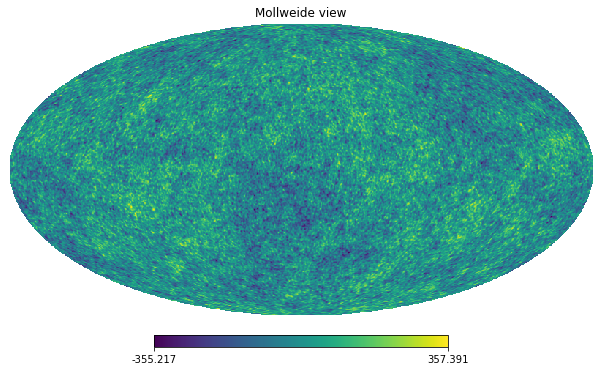

In [3]:
hp.mollview(hp.synfast(np.transpose(unlensedCL),512,fwhm=0.5*np.pi/180)[0])   #Windowfunction 30 arcmin FWHM (filtered high multipoles)

In [3]:
#LiteBIRD
totTQU=hp.synfast(np.transpose(totCL),512,new=True,fwhm=30*np.pi/180/60)   #  TT EE BB TE TB EB     'new' parameter
unlensedTQU=hp.synfast(np.transpose(unlensedCL),512,new=True,fwhm=30*np.pi/180/60)

#no need for DW, UD , LAT

#6.2'
totTQU_PICO=hp.synfast(np.transpose(totCL),512,new=True,fwhm=6.2*np.pi/180/60)   #  TT EE BB TE TB EB     'new' parameter
unlensedTQU_PICO=hp.synfast(np.transpose(unlensedCL),512,new=True,fwhm=6.2*np.pi/180/60)

#17'
totTQU_SAT=hp.synfast(np.transpose(totCL),512,new=True,fwhm=17*np.pi/180/60)   #  TT EE BB TE TB EB     'new' parameter
unlensedTQU_SAT=hp.synfast(np.transpose(unlensedCL),512,new=True,fwhm=17*np.pi/180/60)

In [4]:
unlensedTQU_TEB=hp.anafast(unlensedTQU)

In [5]:
#obtain each pixel's angle position
pix=np.arange(0,hp.nside2npix(Nside))
ang=np.asarray(hp.pix2ang(Nside,pix))

In [6]:
cmbmap_0pointing=hp.synfast(np.transpose(unlensedCL),512)
cmbmap_0pointing.shape

(3, 3145728)

In [14]:
# ramdom pointing

fwhm = np.array([1, 1.25, 1.5, 1.75,  2, 2.25, 2.5,  2.75, 3, 3.5, 4, 4.5,  5, 5.5, 6, 6.5, 7, 8, 9, 10, 15, 20])*np.pi/180/60 #random in radius arcmin expressed in radian

sigma= fwhm /2/np.sqrt(2*np.log(2))


#create empty sets for each sigma value
ang_pointing=np.zeros((len(sigma), 2, hp.nside2npix(Nside)))  
pix_pointing=np.zeros((len(sigma), 1, len(pix)),dtype=int)
TQU_pointing=np.zeros((len(sigma), 3, len(unlensedTQU[0])))
TEB_pointing=np.zeros((len(sigma), 6, len(unlensedTQU_TEB[0])))
TQU_SAT_pointing=np.zeros((len(sigma), 3, len(unlensedTQU[0])))
TEB_SAT_pointing=np.zeros((len(sigma), 6, len(unlensedTQU_TEB[0])))
TQU_PICO_pointing=np.zeros((len(sigma), 3, len(unlensedTQU[0])))
TEB_PICO_pointing=np.zeros((len(sigma), 6, len(unlensedTQU_TEB[0])))

for j in np.arange(len(sigma)):    
    for i in np.arange(0,hp.nside2npix(Nside)):
        random_pointing_r = abs(np.random.normal(0, sigma[j]))   #random in radius, uniform in direction
        random_pointing_a = np.random.uniform(0,2*np.pi)
        ang_pointing[j][0][i]=ang[0][i]+random_pointing_r*math.cos(random_pointing_a)  #theta
        ang_pointing[j][1][i]=ang[1][i]+random_pointing_r*math.sin(random_pointing_a)/math.cos(ang[0][i]-np.pi/2) #phi
   
        if ang_pointing[j][0][i]>np.pi:          # regulations
            ang_pointing[j][0][i]=2*np.pi-ang_pointing[j][0][i];
        if ang_pointing[j][0][i]<0:
            ang_pointing[j][0][i]=-ang_pointing[j][0][i];
        if ang_pointing[j][1][i]>2*np.pi:
            ang_pointing[j][1][i]=ang_pointing[j][0][i]-2*np.pi;
        if ang_pointing[j][1][i]<0:
            ang_pointing[j][1][i]=ang_pointing_ap[j][0][i]+2*np.pi;

    pix_pointing[j]=hp.ang2pix(Nside,ang_pointing[j][0],ang_pointing[j][1])  #to healpy pixel

    for l in [0,1,2]:
        TQU_pointing[j][l]=unlensedTQU[l][pix_pointing[j]]    # fancy indexing
        TQU_SAT_pointing[j][l]=unlensedTQU_SAT[l][pix_pointing[j]]
        TQU_PICO_pointing[j][l]=unlensedTQU_PICO[l][pix_pointing[j]]
        
    TEB_pointing[j]=hp.anafast(TQU_pointing[j])
    TEB_SAT_pointing[j]=hp.anafast(TQU_SAT_pointing[j])
    TEB_PICO_pointing[j]=hp.anafast(TQU_PICO_pointing[j])    

In [16]:
# ramdom pointing, large sigma for litebird and SAT

fwhm_ap = np.array([25, 30, 35, 40, 45, 90])*np.pi/180/60 #random in radius arcmin expressed in radian

sigma_ap= fwhm_ap /2/np.sqrt(2*np.log(2))


#create empty sets for each sigma value
ang_pointing_ap=np.zeros((len(sigma_ap), 2, hp.nside2npix(Nside)))  
pix_pointing_ap=np.zeros((len(sigma_ap), 1, len(pix)),dtype=int)
TQU_pointing_ap=np.zeros((len(sigma_ap), 3, len(unlensedTQU[0])))
TEB_pointing_ap=np.zeros((len(sigma_ap), 6, len(unlensedTQU_TEB[0])))
TQU_SAT_pointing_ap=np.zeros((len(sigma_ap), 3, len(unlensedTQU[0])))
TEB_SAT_pointing_ap=np.zeros((len(sigma_ap), 6, len(unlensedTQU_TEB[0])))
TQU_PICO_pointing_ap=np.zeros((len(sigma_ap), 3, len(unlensedTQU[0])))
TEB_PICO_pointing_ap=np.zeros((len(sigma_ap), 6, len(unlensedTQU_TEB[0])))

for j in np.arange(len(sigma_ap)):    
    for i in np.arange(0,hp.nside2npix(Nside)):
        random_pointing_r = abs(np.random.normal(0, sigma_ap[j]))   #random in radius, uniform in direction
        random_pointing_a = np.random.uniform(0,2*np.pi)
        ang_pointing_ap[j][0][i]=ang[0][i]+random_pointing_r*math.cos(random_pointing_a)  #theta
        ang_pointing_ap[j][1][i]=ang[1][i]+random_pointing_r*math.sin(random_pointing_a)/math.cos(ang[0][i]-np.pi/2) #phi
   
        if ang_pointing_ap[j][0][i]>np.pi:          # regulations
            ang_pointing_ap[j][0][i]=2*np.pi-ang_pointing_ap[j][0][i];
        if ang_pointing_ap[j][0][i]<0:
            ang_pointing_ap[j][0][i]=-ang_pointing_ap[j][0][i];
        if ang_pointing_ap[j][1][i]>2*np.pi:
            ang_pointing_ap[j][1][i]=ang_pointing_ap[j][0][i]-2*np.pi;
        if ang_pointing_ap[j][1][i]<0:
            ang_pointing_ap[j][1][i]=ang_pointing_ap[j][0][i]+2*np.pi;

    pix_pointing_ap[j]=hp.ang2pix(Nside,ang_pointing_ap[j][0],ang_pointing_ap[j][1])  #to healpy pixel

    for l in [0,1,2]:
        TQU_pointing_ap[j][l]=unlensedTQU[l][pix_pointing_ap[j]]    # fancy indexing
        TQU_SAT_pointing_ap[j][l]=unlensedTQU_SAT[l][pix_pointing_ap[j]]
        
    TEB_pointing_ap[j]=hp.anafast(TQU_pointing_ap[j])
    TEB_SAT_pointing_ap[j]=hp.anafast(TQU_SAT_pointing_ap[j])   
    
%store TEB_pointing_ap
%store TEB_SAT_pointing_ap
    

Stored 'TEB_pointing_ap' (ndarray)
Stored 'TEB_SAT_pointing_ap' (ndarray)


In [13]:
# #Filtering small spikes in the BB noise
# from scipy import signal

# TEB_pointing_filtered=np.copy(TEB_pointing)
# unlensedTQU_TEB_filtered=np.copy(unlensedTQU_TEB)

# unlensedTQU_TEB_filtered[1]=np.exp(signal.medfilt(np.log(unlensedTQU_TEB_filtered[1]),kernel_size=31))
# for j in np.arange(len(sigma)):
#     TEB_pointing_filtered[j][2]=np.exp(signal.medfilt(np.log(TEB_pointing[j][2]),kernel_size=31))

In [15]:
# cp1=camb.read_ini('planck_2018_acc_np_params.ini')  

# #compare with primordial B mode
# inflation_params = initialpower.InitialPowerLaw()
# inflation_params.set_params( r=0.01)
# results = camb.get_transfer_functions(cp1)
# results.power_spectra_from_transfer(inflation_params)
# cl56 = results.get_unlensed_total_cls(1500, CMB_unit='muK')

# inflation_params.set_params( r=0.001)
# results = camb.get_transfer_functions(cp1)
# results.power_spectra_from_transfer(inflation_params)
# cl01 = results.get_unlensed_total_cls(1500, CMB_unit='muK')

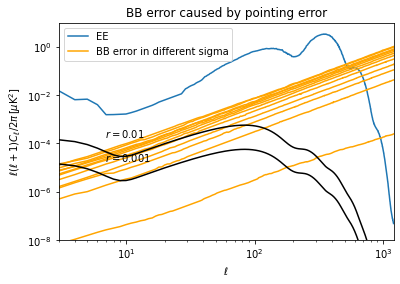

In [23]:
# ls=np.arange(1,3*512+1) #smoothing already did in hp.synfast
# fwhm=30*np.pi/180/60
# sigma1=fwhm/2/(np.sqrt(2*np.log(2)))

# plt.plot(ls,unlensedTQU_TEB_filtered[1]*ls*(ls+1)/2/np.pi)
# for i in np.arange(len(sigma)):
#     plt.plot(ls,TEB_pointing_filtered[i][2]*ls*(ls+1)/2/np.pi, color='orange')
# plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi\,[\mu {\rm K}^2]$')
# plt.xlabel(r'$\ell$')
# plt.plot(np.arange(1501),cl56[:,2]*np.exp(-np.arange(1501)*(np.arange(1501)+1)*sigma1**2),'black',label='PGWB')
# plt.plot(np.arange(1501),cl01[:,2]*np.exp(-np.arange(1501)*(np.arange(1501)+1)*sigma1**2),'black')

# plt.annotate(r'$r=0.01$',xy=(4,0.003),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='black')
# plt.annotate(r'$r=0.001$',xy=(4,0.0003),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='black')


# plt.yscale('log')
# plt.xscale('log')
# plt.legend(['EE','BB error in different sigma'])
# plt.title('BB error caused by pointing error')      
# plt.xlim([3,1200])
# plt.ylim([0.00000001,10])
# plt.show()


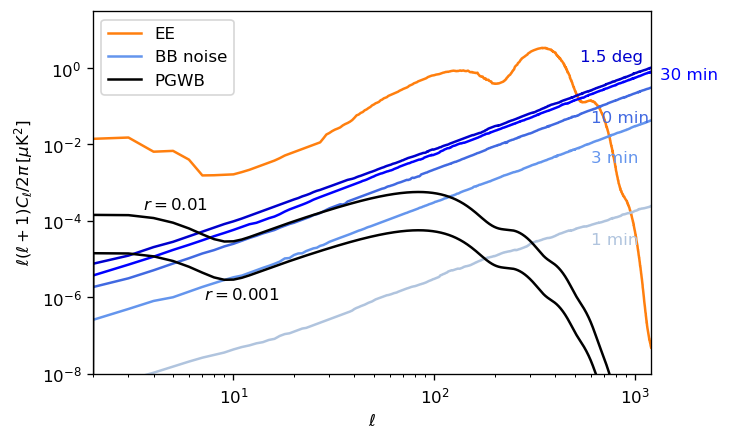

In [67]:
# ls=np.arange(1,3*512+1) #smoothing already did in hp.synfast
# fwhm=30*np.pi/180/60
# sigma1=fwhm/2/(np.sqrt(2*np.log(2)))


# plt.figure(dpi=120)
# plt.plot(ls,unlensedTQU_TEB_filtered[1]*ls*(ls+1)/2/np.pi, color='C1',label='EE')
# plt.plot(ls,TEB_pointing_filtered[0][2]*ls*(ls+1)/2/np.pi, color='lightsteelblue')
# plt.plot(ls,TEB_pointing_filtered[1][2]*ls*(ls+1)/2/np.pi, color='cornflowerblue',label='BB noise')
# plt.plot(ls,TEB_pointing_filtered[4][2]*ls*(ls+1)/2/np.pi, color='royalblue')
# plt.plot(ls,TEB_pointing_filtered[9][2]*ls*(ls+1)/2/np.pi, color='blue')
# plt.plot(ls,TEB_pointing_filtered[11][2]*ls*(ls+1)/2/np.pi, color='mediumblue')

# plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi\,[\mu {\rm K}^2]$')
# plt.xlabel(r'$\ell$')
# plt.plot(np.arange(1501),cl56[:,2]*np.exp(-np.arange(1501)*(np.arange(1501)+1)*sigma1**2),'black',label='PGWB')
# plt.plot(np.arange(1501),cl01[:,2]*np.exp(-np.arange(1501)*(np.arange(1501)+1)*sigma1**2),'black')

# plt.annotate(r'$r=0.01$',xy=(2,0.004),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='black')
# plt.annotate(r'$r=0.001$',xy=(4,0.000018),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='black')

# plt.annotate('1 min',xy=(340,0.0005),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='lightsteelblue')
# plt.annotate('3 min',xy=(340,0.07),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='cornflowerblue')
# plt.annotate('10 min',xy=(340,0.75),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='royalblue')
# plt.annotate('30 min',xy=(750,10),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='blue')
# plt.annotate('1.5 deg',xy=(300,30),xytext=(+30,-30),textcoords='offset points',fontsize=10,color='mediumblue')

# plt.yscale('log')
# plt.xscale('log')
# plt.legend(loc=0)
# #plt.title('BB error caused by pointing error')      
# plt.xlim([2,1200])
# plt.ylim([0.00000001,30])
# plt.show()

In [15]:
%store TEB_pointing
%store TEB_SAT_pointing
%store TEB_PICO_pointing

Stored 'TEB_pointing' (ndarray)
Stored 'TEB_SAT_pointing' (ndarray)
Stored 'TEB_PICO_pointing' (ndarray)
